# Parallel Tempering with MPI

Parallel tempering is a technique for improving the efficiency of MCMC, especially in the case of multi-modal target distributions. The core idea is to build a sequence of distributions starting with an easy-to-sample reference (e.g. the prior) and ending with the difficult-to-sample target (e.g. the posterior). Given the target $\pi$ and the reference $\pi_0$, this sequence is constructed using a "temperature" parameter $0 < \beta < 1$:
$$\pi_\beta = \pi_0^{1-\beta} \cdot \pi^\beta$$
Here, for $\beta = 0$ (also referred to as "cold" chain) the distribution is equal to the target, for $\beta = 1$ (also referred to as "hot" chain) it is equal to the reference. By running multiple chains with an ascending sequence of temperatures $\beta_0 = 0, \beta_1, \dots, \beta_n = 1$ and allowing theses chains to pass states based on Metropolis-Hastings, the simpler properties of hotter distributions improve the exploration of the state space and can result in faster convergence of the cold chain to the target distribution.

*hopsy* implements parallel tempering. This notebook illustrates it by sampling a mixture of Gaussians that has two distinct modes. Depending on the starting point, vanilla MCMC approaches have trouble capturing the multi-modality. This is because once the chain has found a mode, Metropolis-Hastings proposal are very unlikely to propose high-density points in the other mode. With parallel tempering, the hotter chains are less effected by this and can better sample broadly. By passing these states on to the colder chains, other modes can be explored.

In [5]:
import numpy as np
import hopsy
import multiprocessing
import ipyparallel as ipp

import matplotlib.pyplot as plt

The sampling code with all imports must be defined within a file or function like here. The code is later called by an MPI process, enabling communication of the tempered chains in *HOPS*. Notice, that for the definition of the Markov chain, a synchronized `RandomNumberGenerator` (must have the same seed for each process!) and an exchange probability must be given.

Important: For technical reasons it is not possible to use multiple chains from each MPI process. A different way of generating replica chains for computing statistics is shown below. 

In [6]:
def run_tempered_chain(n_samples: int, chain_idx: int):
    import hopsy
    import numpy as np
    from mpi4py import MPI

    class GaussianMixture:
        def __init__(self, mu1, mu2):
            epsilon = 0.05
            cov = epsilon * np.eye(2, 2)
            self.model1 = hopsy.Gaussian(mean=mu1, covariance=cov)
            self.model2 = hopsy.Gaussian(mean=mu2, covariance=cov)

        def compute_negative_log_likelihood(self, x):
            return -np.log(
                np.exp(-self.model1.compute_negative_log_likelihood(x))
                + np.exp(-self.model2.compute_negative_log_likelihood(x))
            )
        
    A = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
    b = np.array([1, 1, 1, 1])

    model = GaussianMixture(np.ones(2).reshape(2, 1), -np.ones(2).reshape(2, 1))
    problem = hopsy.Problem(A, b, model)

    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()

    syncRng = hopsy.RandomNumberGenerator(42)
    mc = hopsy.MarkovChain(
        proposal=hopsy.GaussianCoordinateHitAndRunProposal,
        problem=problem,
        parallel_tempering_sync_rng=syncRng,
        exchange_attempt_probability=0.15,
        starting_point=0.9 * np.ones(2))
    mc.proposal.stepsize = 0.25

    rng = hopsy.RandomNumberGenerator(rank + chain_idx + 11)

    acc_rate, samples = hopsy.sample(markov_chains=mc, rngs=rng, n_samples=n_samples)
    return acc_rate, samples, rank

The following function implements running MPI processes from within notebooks using `ipyparallel`. An different strategy would be to place your code in a Python file and invoking the processes using `mpiexec` from the command line.

In [7]:
def run_tempered_chains(n_samples: int, n_temps: int, chain_idx: int):
    with ipp.Cluster(engines='mpi', n=n_temps) as rc:
        view = rc.broadcast_view()
        result = view.apply_sync(run_tempered_chain, n_samples, chain_idx)
    result = sorted(result, key=lambda x: x[2])

    return [r[1] for r in result]

Because this approach is hard to debug, it is generally a good idea to run a single instance of tempered chains for a short time before running large numbers of samples.

In [8]:
_ = run_tempered_chains(10, 5, 0)

Starting 5 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.09s/engine]
Stopping engine(s): 1686395190
engine set stopped 1686395190: {'exit_code': 1, 'pid': 15143, 'identifier': 'ipengine-1686395189-mxy1-1686395190-13460'}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 15084, 'identifier': 'ipcontroller-1686395189-mxy1-13460'}


Using multiprocessing, multiple replicas of tempered chains can be run in parallel. This is simply done by using the `multiprocessing` module and calling the spawning function from before in different subprocesses.

In [9]:
n_samples = 550000
n_replicas = 4
n_temps = 5

with multiprocessing.Pool(n_replicas) as pool:
    result = pool.starmap(run_tempered_chains, [(n_samples, n_temps, chain_idx) for chain_idx in range(n_replicas)])

Starting 5 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
Starting 5 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
Starting 5 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
Starting 5 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.12s/engine]
Stopping engine(s): 1686395200
Stopping controller
Stopping engine(s): 1686395200
Stopping controller
Stopping engine(s): 1686395200
Stopping engine(s): 1686395200
Stopping controller
Stopping controller


Assemble cold-chain samples and compute statistics:

In [10]:
samples = np.array([result[i][0][0] for i in range(n_replicas)])
hopsy.rhat(samples), hopsy.ess(samples)

(array([[1.00129537, 1.00123599]]), array([[2691.51743799, 2614.77034169]]))

The cold chains seem to have converged. The following plot illustrates posteriors of all tempered distributions. The multi-modality is very well captured by all replicas.

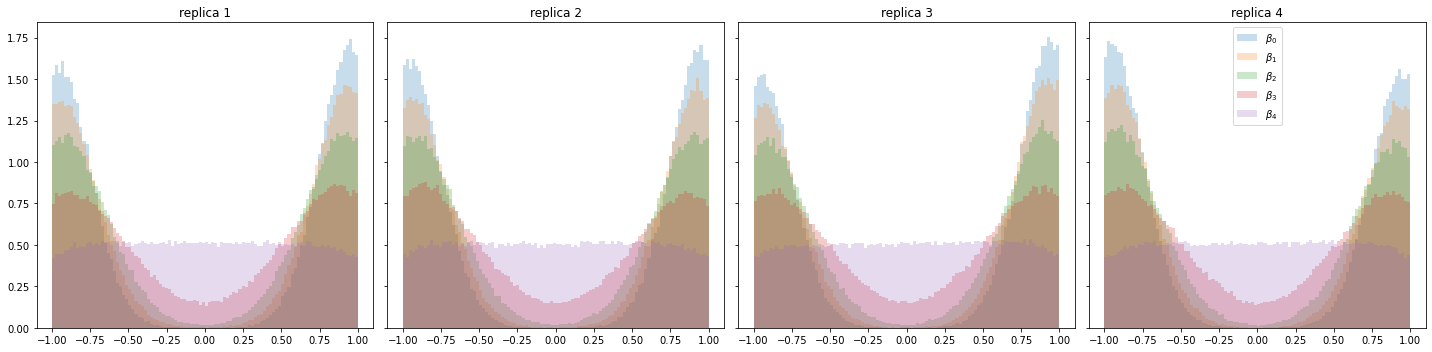

In [11]:
fig, axs = plt.subplots(1, n_replicas, sharey=True, figsize=(20, 5))
for i in range(n_replicas):
    ax = axs[i]
    ax.set_title(f"replica {i+1}")
    for j in range(n_temps):
        ax.hist(result[i][j][:, :, 0].flatten(), density=True, alpha=0.245, label="$\\beta_"+str(j)+"$", bins=100)
plt.tight_layout()
plt.legend()
plt.show()